In [8]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
from ase.cluster import Decahedron
import matplotlib.pyplot as plt
import numpy as np

(examples:prism_quickstart)=
# PRISM quickstart

This is a short example of running a STEM simulation of a supported nanoparticle with the PRISM algorithm. See our [tutorial](tutorials:prism) for a more in depth description.  

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [6]:
abtem.config.set({"device": "gpu", "fft": "fftw"})

## Atomic model

We create an atomic model of a decahedral copper nanoparticle. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

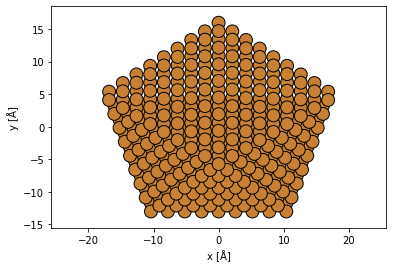

In [9]:
cluster = Decahedron("Cu", 9, 2, 0)
cluster.rotate("x", -30)

abtem.show_atoms(cluster, plane="xy");

A rough model of amorphous carbon is created by randomly displacing the atoms of a diamond structure

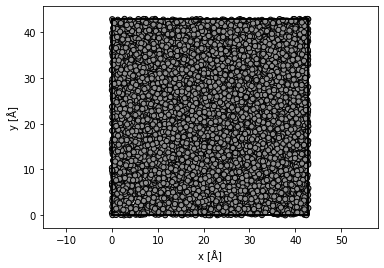

In [10]:
substrate = ase.build.bulk("C", cubic=True)

# repeat diamond structure
substrate *= (12, 12, 10)

# displace atoms with a standard deviation of 50 % of the bond length
bondlength = 1.54  # Bond length
substrate.positions[:] += np.random.randn(len(substrate), 3) * 0.5 * bondlength

# wrap the atoms displaced outside the cell back into the cell
substrate.wrap()

abtem.show_atoms(substrate, plane="xy", merge=0.5);

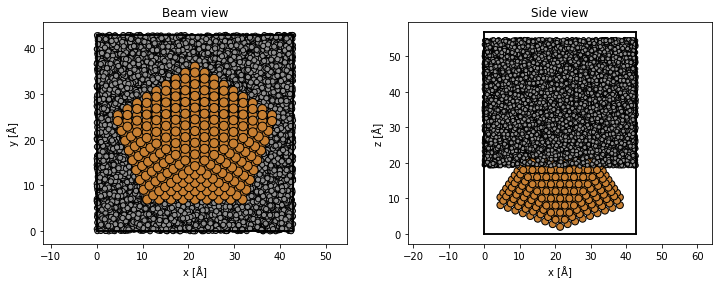

In [11]:
translated_cluster = cluster.copy()

translated_cluster.cell = substrate.cell
translated_cluster.center()
translated_cluster.translate((0, 0, -25))

atoms = substrate + translated_cluster

atoms.center(axis=2, vacuum=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, plane="xy", ax=ax1, title="Beam view")
abtem.show_atoms(atoms, plane="xz", ax=ax2, title="Side view");

## Potential

We create an ensemble of potentials using the frozen phonon model. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [12]:
frozen_phonons = abtem.FrozenPhonons(atoms, 4, sigmas=0.1)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [32]:
potential = abtem.Potential(
    frozen_phonons,
    gpts=1024,
    slice_thickness=2,
)

## SMatrix

We create the ensemble of SMatrices by providing our potential, an acceleration voltage $200 \ \mathrm{keV}$, a cutoff of the plane wave expansion of the probe of $20 \ \mathrm{mrad}$ and an interpolation factor of 4 in both $x$ and $y$. See our [tutorial on PRISM](tutorials:prism)

In [57]:
s_matrix = abtem.SMatrix(
    potential=potential, energy=200e3, semiangle_cutoff=20, interpolation=4
)

s_matrix.shape

(4, 253, 1024, 1024)

## Contrast transfer function

To include defocus, spherical aberration and other phase aberrations, we should define a contrast transfer function. Here we create one with a spherical aberration of $20 \ \mu m$, the defocus is adjusted to the according Scherzer defocus.

In [115]:
Cs = 8e-6 * 1e10  # 20 micrometers

ctf = abtem.CTF(Cs=Cs, defocus="scherzer", energy=s_matrix.energy)

print(f"defocus = {ctf.defocus} Å")

defocus = 54.859099865741655 Å


We always ensure that the interpolation factor is sufficiently small to avoid self-interaction errors. We can check that by showing the equivalent probe at the entrance and exit plane.

[########################################] | 100% Completed | 113.21 ms
[########################################] | 100% Completed | 109.72 ms


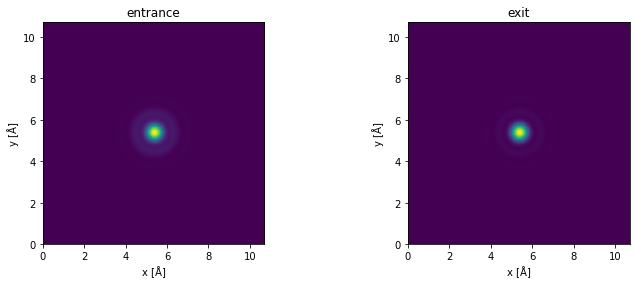

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
s_matrix.dummy_probes(plane="entrance", ctf=ctf).show(ax=ax1, title="entrance", power=1)
s_matrix.dummy_probes(plane="exit", ctf=ctf).show(ax=ax2, title="exit", power=1);

We should also check that our real space sampling is good enough for detecting electrons at our desired detector angles. In this case up to $165 \ \mathrm{mrad}$. See our [description of sampling](appendix:antialiasing).

In [117]:
s_matrix.cutoff_angles

(199.62780224577517, 199.62780224577517)

## Create a CTF, a detector and a scan

In [118]:
detectors = abtem.FlexibleAnnularDetector()

In [119]:
flexible_measurement = s_matrix.scan(detectors=detectors, ctf=ctf)

1

In [120]:
flexible_measurement.compute()

[########################################] | 100% Completed | 18.18 s


## Integrate measurements

The measurements are integrated to obtain the bright field, medium-angle annular dark field and high-angle annular dark field signals.

In [123]:
bf_measurement = flexible_measurement.integrate_radial(0, s_matrix.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(45, 150)
haadf_measurement = flexible_measurement.integrate_radial(70, 190)

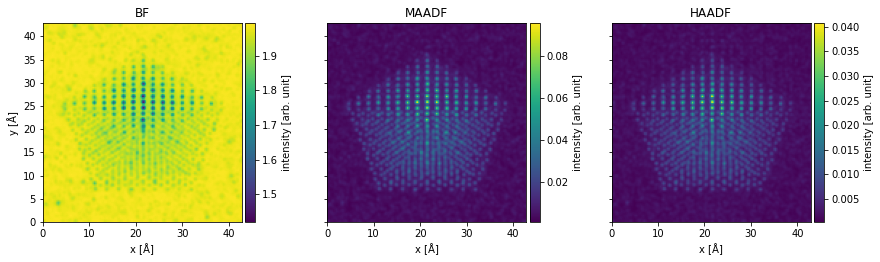

In [124]:
measurements = abtem.stack(
    [bf_measurement, maadf_measurement, haadf_measurement], ("BF", "MAADF", "HAADF")
)

measurements.show(
    explode=True,
    figsize=(14, 5),
    image_grid_kwargs={"axes_pad": 1},
    cbar=True,
);

## Postprocessing

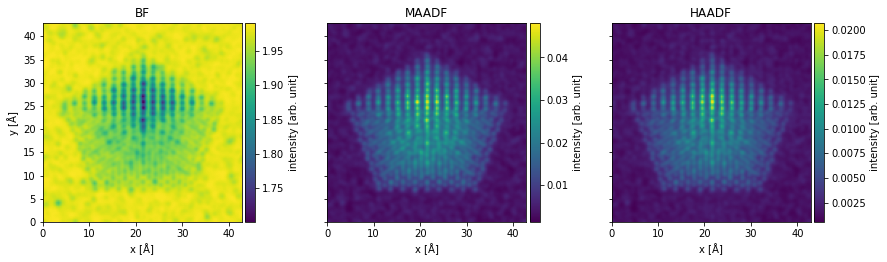

In [125]:
filtered_measurements = measurements.gaussian_filter(0.35)

filtered_measurements.show(
    explode=True,
    figsize=(14, 5),
    image_grid_kwargs={"axes_pad": 1},
    cbar=True,
);

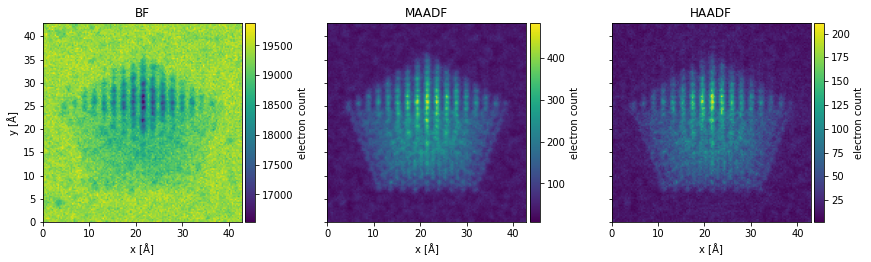

In [126]:
noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=1e5)

noisy_measurements.show(
    explode=True,
    figsize=(14, 5),
    image_grid_kwargs={"axes_pad": 1},
    cbar=True,
);

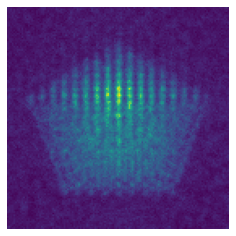

In [127]:
fig, ax = noisy_measurements[-1].show()
ax.axis("off")
plt.savefig("../thumbnails/prism_quickstart.png", bbox_inches="tight", pad_inches=0)